# Run below line to install all dependencies
#requireent for notebook

In [1]:
# pip3 install -r requirements.txt

# Project description 
Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.

PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.

Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics. As one example, PetFinder is currently experimenting with a simple AI tool called the Cuteness Meter, which ranks how cute a pet is based on qualities present in their photos.

In this competition you will be developing algorithms to predict the adoptability of pets - specifically, how quickly is a pet adopted? If successful, they will be adapted into AI tools that will guide shelters and rescuers around the world on improving their pet profiles' appeal, reducing animal suffering and euthanization.

Top participants may be invited to collaborate on implementing their solutions into AI tools for assessing and improving pet adoption performance, which will benefit global animal welfare.

In [2]:
#Loading libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# File descriptions
train.csv - Tabular/text data for the training set
test.csv - Tabular/text data for the test set
sample_submission.csv - A sample submission file in the correct format
breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
color_labels.csv - Contains ColorName for each ColorID
state_labels.csv - Contains StateName for each StateID

# Image Metadata
We have run the images through Google's Vision API, providing analysis on Face Annotation, Label Annotation, Text Annotation and Image Properties. You may optionally utilize this supplementary information for your image analysis.

File name format is PetID-ImageNumber.json.

Some properties will not exist in JSON file if not present, i.e. Face Annotation. Text Annotation has been simplified to just 1 entry of the entire text description (instead of the detailed JSON result broken down by individual characters and words). Phone numbers and emails are already anonymized in Text Annotation.

# Sentiment Data
We have run each pet profile's description through Google's Natural Language API, providing analysis on sentiment and key entities. You may optionally utilize this supplementary information for your pet description analysis. There are some descriptions that the API could not analyze. As such, there are fewer sentiment files than there are rows in the dataset.

File name format is PetID.json.

In [3]:
#loading data
train = pd.read_csv("data/train/train.csv")
test = pd.read_csv("data/test/test.csv")
breed_labels = pd.read_csv("data/breed_labels.csv")
color_labels = pd.read_csv("data/color_labels.csv")
state_labels = pd.read_csv("data/state_labels.csv")

# Data Fields
Data Fields
PetID - Unique hash ID of pet profile

AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.

Type - Type of animal (1 = Dog, 2 = Cat)

Name - Name of pet (Empty if not named)

Age - Age of pet when listed, in months

Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)

Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to 
BreedLabels dictionary)

Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

Color1 - Color 1 of pet (Refer to ColorLabels dictionary)

Color2 - Color 2 of pet (Refer to ColorLabels dictionary)

Color3 - Color 3 of pet (Refer to ColorLabels dictionary)

MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)

Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)

Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

Quantity - Number of pets represented in profile

Fee - Adoption fee (0 = Free)

State - State location in Malaysia (Refer to StateLabels dictionary)

RescuerID - Unique hash ID of rescuer

VideoAmt - Total uploaded videos for this pet

PhotoAmt - Total uploaded photos for this pet

Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

# AdoptionSpeed
Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:

0 - Pet was adopted on the same day as it was listed. 

1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 

2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 

3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 

4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [4]:
train['AgeInYears'] = train['Age']%12
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,AgeInYears
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,3
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,1
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,1
3,1,Miko,4,307,0,2,1,2,0,2,...,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,4
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,1


In [5]:
test.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,1,Puppy,2,307,0,1,1,0,0,2,...,2,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,"Puppy is calm for a young dog, but he becomes ...",378fcc4fc,3.0
1,2,London,24,266,0,1,2,7,0,2,...,1,1,1,0,41326,4475f31553f0170229455e3c5645644f,0,Urgently seeking adoption. Please contact for ...,73c10e136,1.0
2,2,Snowball,20,266,0,2,7,0,0,2,...,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,Snowball... doesn't look so good (she is healt...,72000c4c5,1.0
3,2,Malibu,5,266,252,2,1,6,7,2,...,1,1,1,100,41326,4475f31553f0170229455e3c5645644f,0,"Malibu: Female, Local Mix, 4-5 months, vaccina...",e147a4b9f,1.0
4,1,Lala Girl,6,307,0,2,1,2,7,2,...,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,LALA! That's my name. I'm a 6 month old girl d...,43fbba852,1.0


In [6]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('----------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],test.shape[1]))

The train data has 14993 rows and 25 columns
----------------------------
The test data has 3948 rows and 23 columns


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

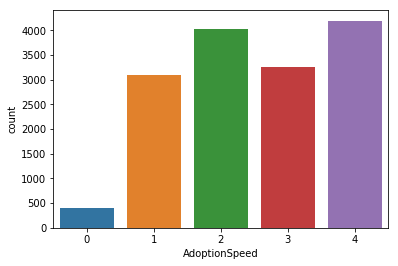

In [8]:
sns.countplot(train.AdoptionSpeed)
# adoptation speed count

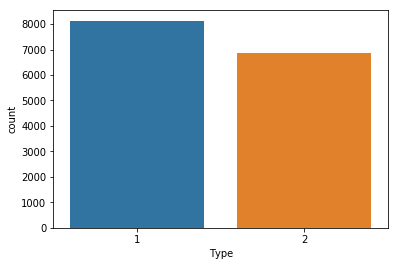

In [9]:
sns.countplot(train.Type)
#cat and dog

In [10]:
#check missing values
train.columns[train.isnull().any()]

Index(['Name', 'Description'], dtype='object')

In [11]:
#missing value counts in each of these columns
miss = train.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Description    0.000800
Name           0.083839
dtype: float64

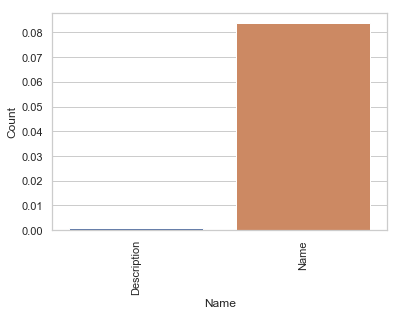

In [12]:
#visulaising missing values
miss = miss.to_frame()
miss.columns = ['Count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes = True )
sns.barplot(x = 'Name', y = 'Count' ,data = miss)
plt.xticks(rotation = 90)
plt.show()

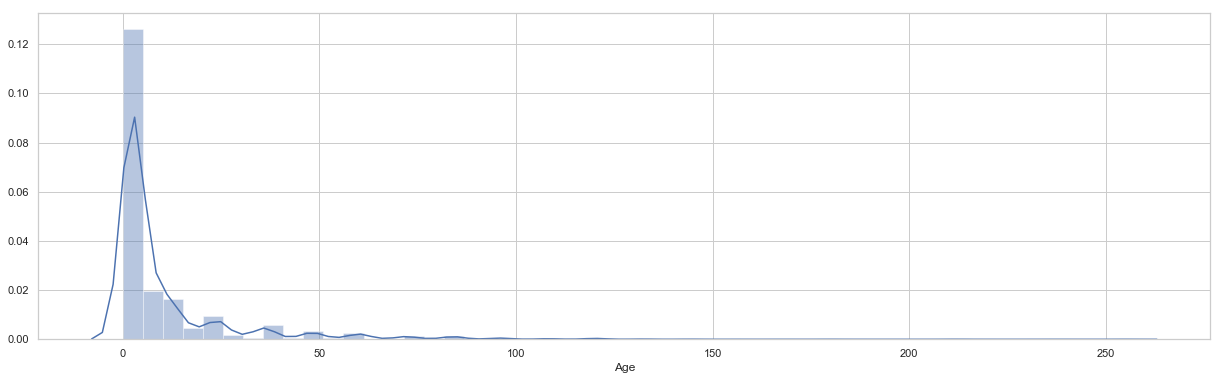

In [13]:
# Checking Age Distribution
f, ax = plt.subplots(figsize=(21, 6))
sns.distplot(train.Age, ax=ax)

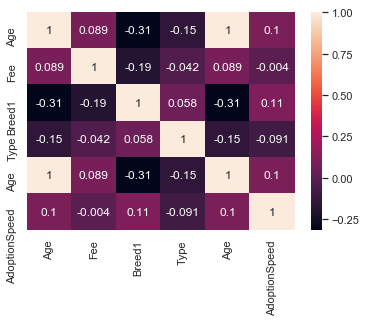

In [14]:
# Checking Age,Fee and AdoptionnSpeed correlation
sns.heatmap(train[['Age', 'Fee','Breed1','Type','Age','AdoptionSpeed']].corr(), annot=True)


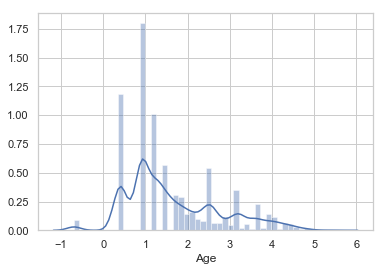

In [15]:
# Since Age is skewed, We can try logarithmic transformation
sns.distplot(np.log(train.Age + 0.5))

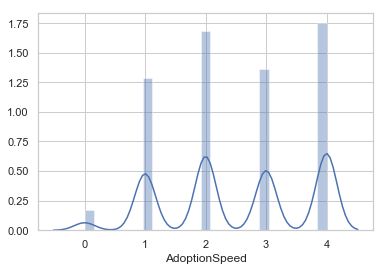

In [16]:
#AdoptionSpeed
sns.distplot(train['AdoptionSpeed'])

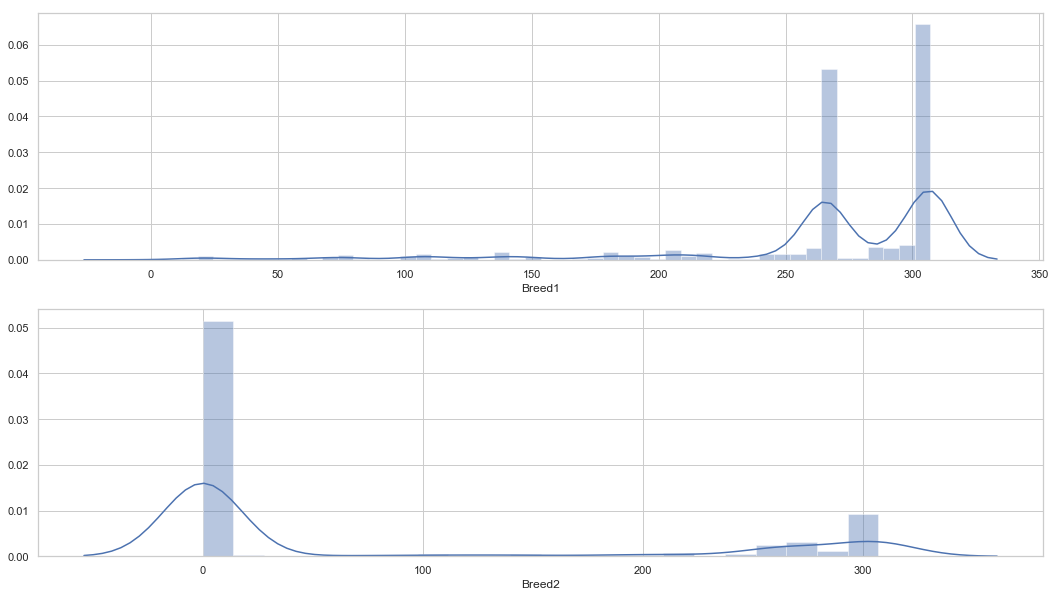

In [17]:
# Checking put distribution of Breed1 and Breed2
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
sns.distplot(train.Breed1, ax=ax[0])
sns.distplot(train.Breed2, ax=ax[1])

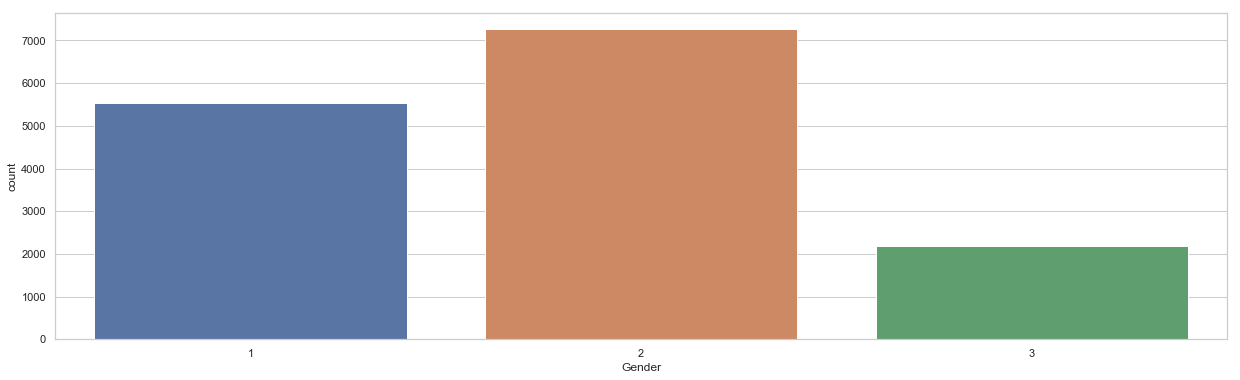

In [18]:
# Gender distribution
f, ax = plt.subplots(figsize=(21, 6))
sns.countplot(train.Gender, ax=ax)

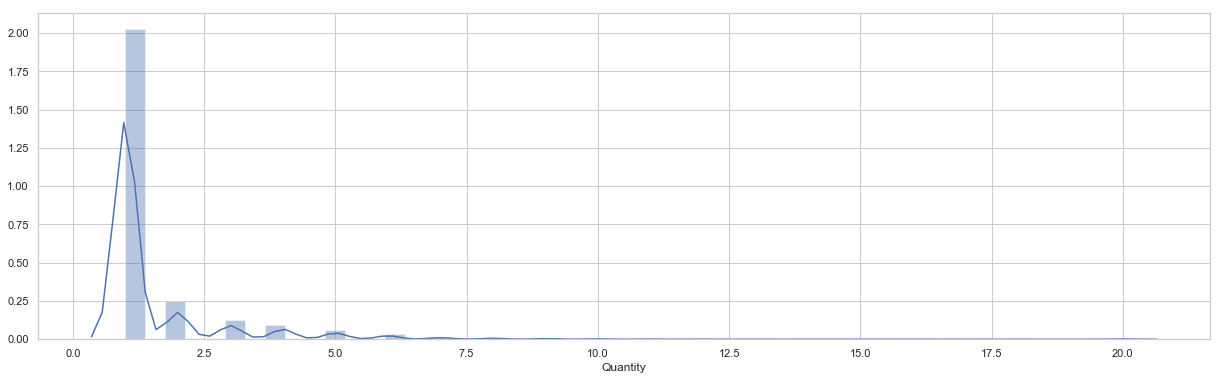

In [19]:
# Quantity Distribution
f, ax = plt.subplots(figsize=(21, 6))
sns.distplot(train.Quantity, ax=ax)

In [20]:
#skewness
print ("The skewness of AdoptionSpeed is {}".format(train['AdoptionSpeed'].skew()))


The skewness of AdoptionSpeed is -0.15505182964303066


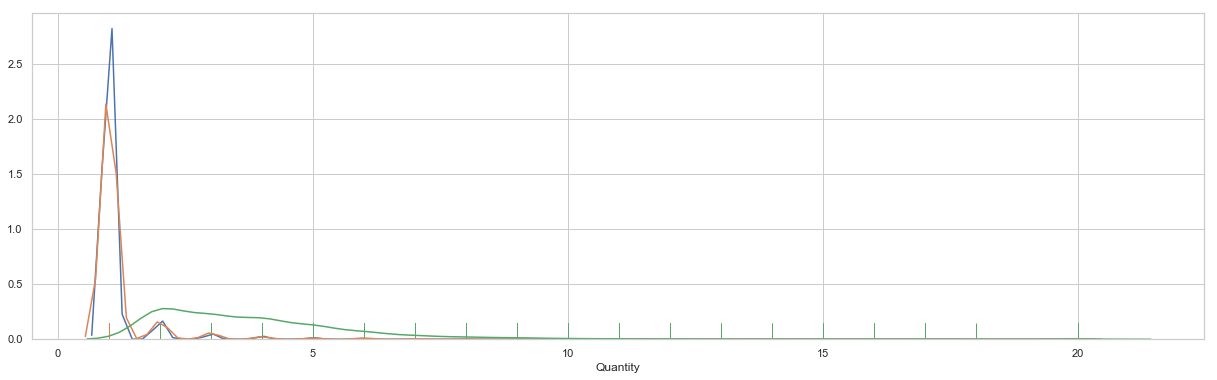

In [21]:
f, ax = plt.subplots(figsize=(21, 6))
quant_gender1 = train[train['Gender'] == 1]
quant_gender2 = train[train['Gender'] == 2]
quant_gender3= train[train['Gender'] == 3]
sns.distplot(quant_gender1.Quantity, ax=ax , hist=False, rug=True)
sns.distplot(quant_gender2.Quantity, ax=ax,  hist=False, rug=True)
sns.distplot(quant_gender3.Quantity, ax=ax,  hist=False, rug=True)
plt.show()

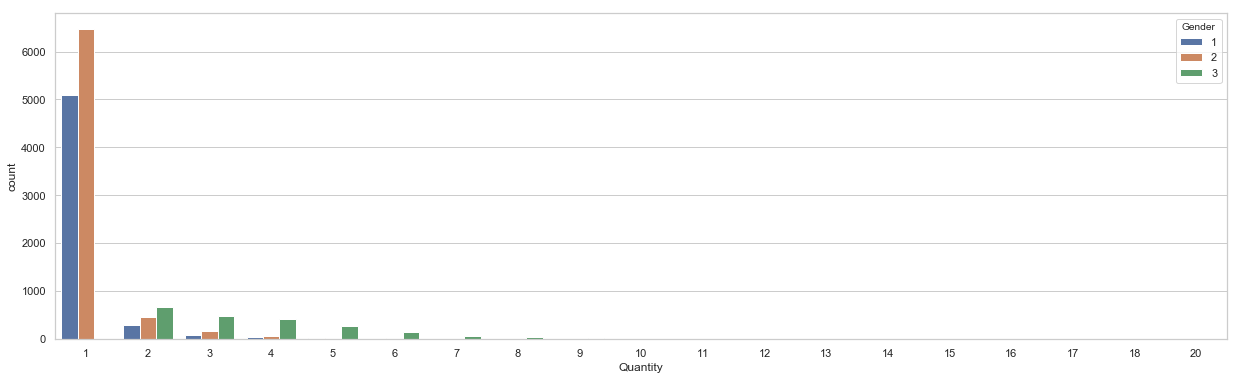

In [22]:
f, ax = plt.subplots(figsize=(21, 6))
sns.countplot('Quantity',data=train,hue='Gender', ax=ax)


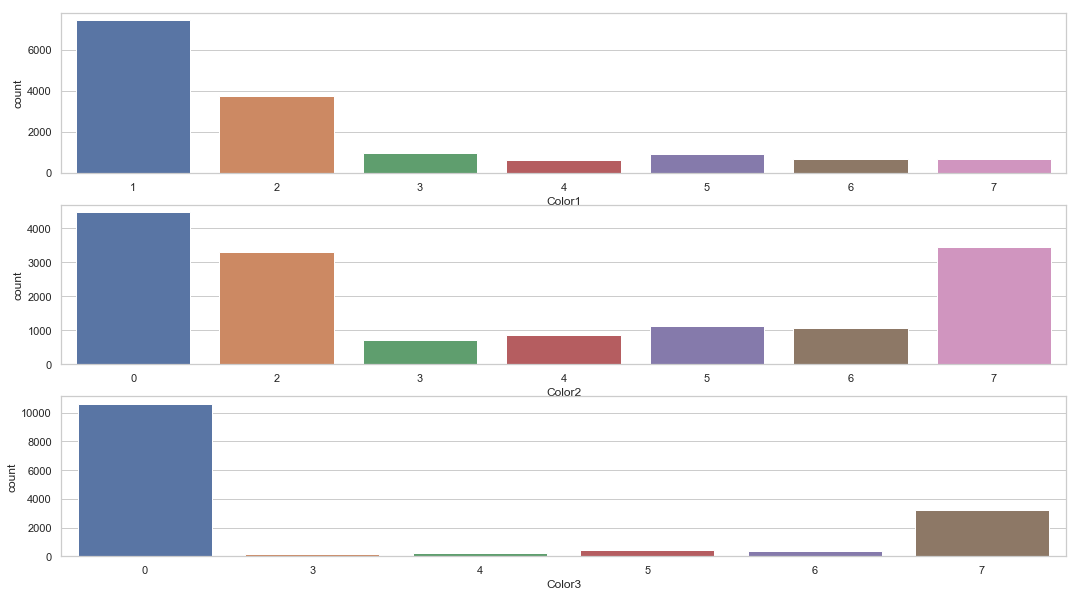

In [23]:
# Color distribution
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18,10))
sns.countplot(train.Color1, ax=ax[0])
sns.countplot(train.Color2, ax=ax[1])
sns.countplot(train.Color3, ax=ax[2])

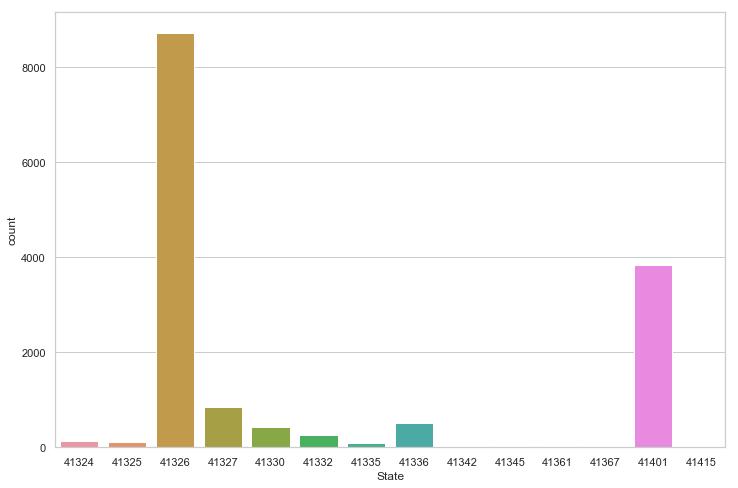

In [24]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(train.State, ax=ax)

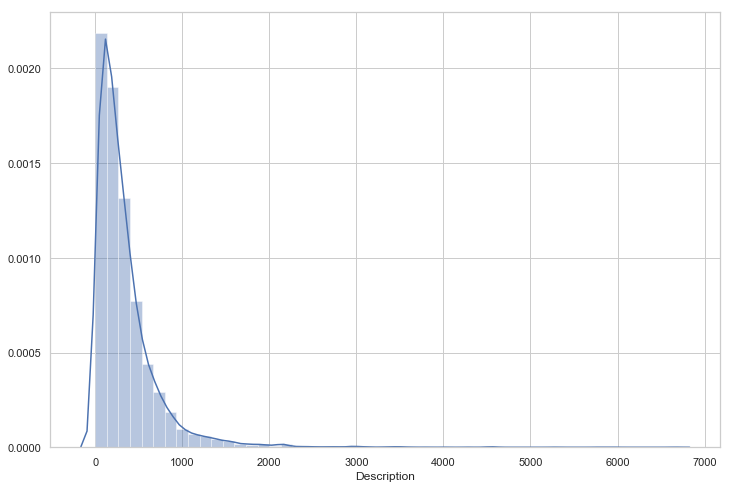

In [25]:
f, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train.Description.fillna('').str.len(), ax=ax)

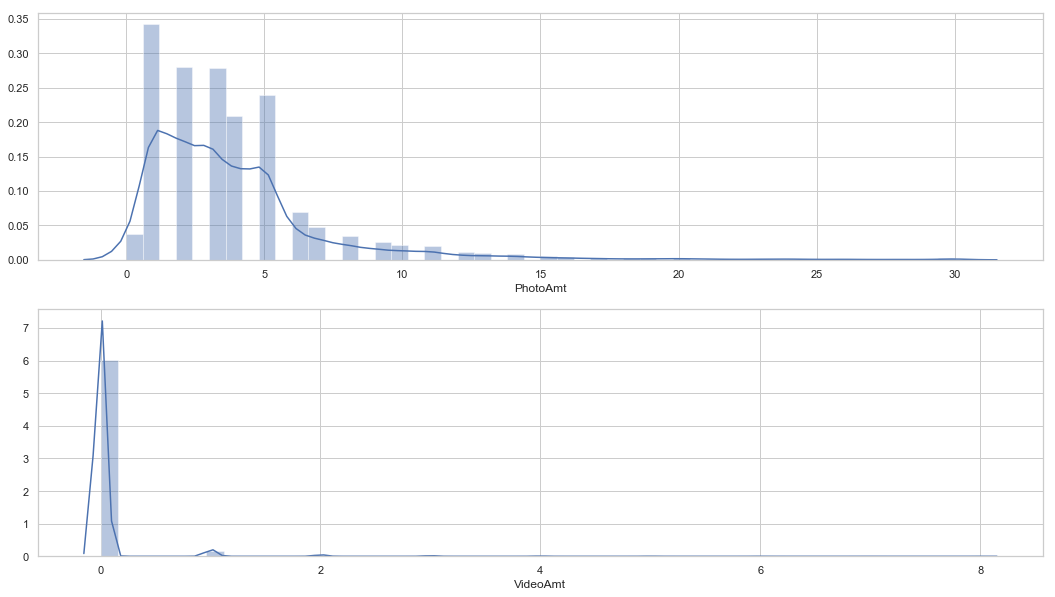

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
sns.distplot(train.PhotoAmt, ax=ax[0])
sns.distplot(train.VideoAmt, ax=ax[1])

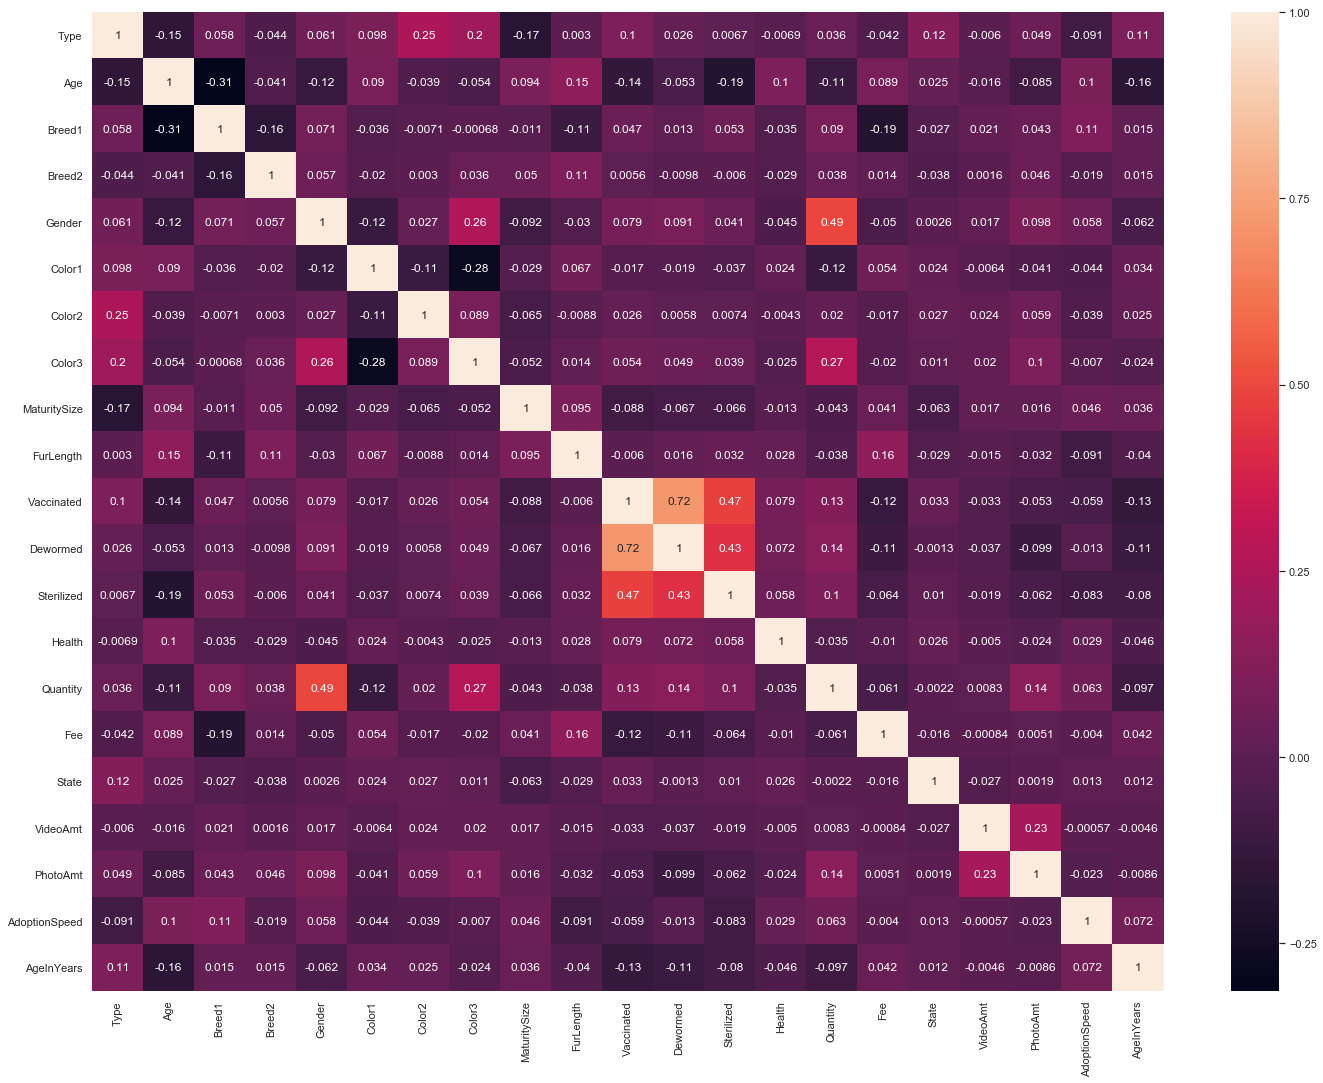

In [27]:
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(train.corr(), annot=True, ax=ax)

Vaccianted, Dewormed and Sterilized are positively correlated

Gender and Quantity are positively correlated

Breed and age are negatively correlated

Adoption speed is not correlated to fee

Skewness is asymmetry in a statistical distribution, in which the curve appears distorted or skewed either to the left or to the right. Skewness can be quantified to define the extent to which a distribution differs from a normal distribution.

In a normal distribution, the graph appears as a classical, symmetrical "bell-shaped curve." The mean, or average, and the mode, or maximum point on the curve, are equal.

In [28]:
#separate variables into new data frames
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))


There are 21 numeric and 4 categorical columns in train data


In [29]:
#del numeric_data['PetID']
#del numeric_data['RescuerID']
numeric_data

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,AgeInYears
0,2,3,299,0,1,1,7,0,1,1,...,2,2,1,1,100,41326,0,1.0,2,3
1,2,1,265,0,1,1,2,0,2,2,...,3,3,1,1,0,41401,0,2.0,0,1
2,1,1,307,0,1,2,7,0,2,2,...,1,2,1,1,0,41326,0,7.0,3,1
3,1,4,307,0,2,1,2,0,2,1,...,1,2,1,1,150,41401,0,8.0,2,4
4,1,1,307,0,1,1,0,0,2,1,...,2,2,1,1,0,41326,0,3.0,2,1
5,2,3,266,0,2,5,6,0,2,1,...,2,2,1,1,0,41326,0,2.0,2,3
6,2,12,264,264,1,1,0,0,2,3,...,2,3,1,1,300,41326,0,3.0,1,0
7,1,0,307,0,2,1,2,7,2,1,...,2,2,1,6,0,41326,0,9.0,3,0
8,2,2,265,0,2,6,0,0,2,2,...,2,2,1,1,0,41326,0,6.0,1,2
9,2,12,265,0,2,1,7,0,2,2,...,3,3,1,1,0,41326,0,2.0,4,0


In [30]:
cat_data

,Name,RescuerID,Description,PetID
0,Nibble,8480853f516546f6cf33aa88cd76c379,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3
1,No Name Yet,3082c7125d8fb66f7dd4bff4192c8b14,I just found it alone yesterday near my apartm...,6296e909a
2,Brisco,fa90fa5b1ee11c86938398b60abc32cb,Their pregnant mother was dumped by her irresp...,3422e4906
3,Miko,9238e4f44c71a75282e62f7136c6b240,"Good guard dog, very alert, active, obedience ...",5842f1ff5
4,Hunter,95481e953f8aed9ec3d16fc4509537e8,This handsome yet cute boy is up for adoption....,850a43f90
5,NaN,22fe332bf9c924d4718005891c63fbed,This is a stray kitten that came to my house. ...,d24c30b4b
6,BULAT,1e0b5a458b5b77f5af581d57ebf570b3,anyone within the area of ipoh or taiping who ...,1caa6fcdb
7,Siu Pak & Her 6 Puppies,1fba5f6e5480946254590d48f9c5198d,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac
8,NaN,d8af7afece71334473575c9f70daf00d,"healthy and active, feisty kitten found in nei...",c06d167ca
9,Kitty,1f3f36e4b18e94855b3e88af0852fdc4,"Very manja and gentle stray cat found, we woul...",7a0942d61


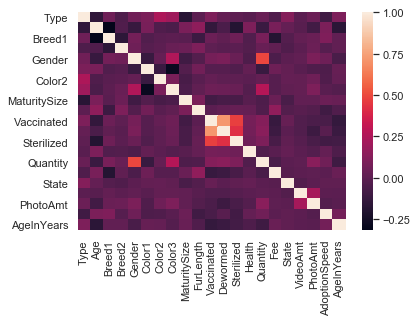

In [31]:
#correlation plot
corr = numeric_data.corr()
sns.heatmap(corr)

In [32]:
print (corr['AdoptionSpeed'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['AdoptionSpeed'].sort_values(ascending=False)[-5:]) #last 5 values`



AdoptionSpeed    1.000000
Breed1           0.107834
Age              0.100510
AgeInYears       0.072232
Quantity         0.062931
Gender           0.057622
MaturitySize     0.045653
Health           0.029382
State            0.013119
VideoAmt        -0.000571
Fee             -0.004017
Color3          -0.007014
Dewormed        -0.013210
Breed2          -0.018642
PhotoAmt        -0.023233
Name: AdoptionSpeed, dtype: float64 

----------------------
Color1       -0.044192
Vaccinated   -0.059043
Sterilized   -0.083447
Type         -0.091240
FurLength    -0.091337
Name: AdoptionSpeed, dtype: float64


Here we see that the Breed1 feature is 10% and Age feature is 10% correlated with the target variable

Breed1 and Age features

In [33]:
train['Breed1'].unique()


array([299, 265, 307, 266, 264, 218, 114, 285, 189, 205, 292, 128, 243,
       213, 141, 173, 207, 250, 119, 195, 109, 206,  70, 103, 303,  78,
       254,  10,  20, 305, 283, 306, 288,  69, 179,  31, 247, 200, 248,
        26,  25,   0, 129, 202,  72,  24, 284, 286, 152, 277,  44,  75,
        64,  60, 296, 185, 300,  76, 139, 242, 294, 276, 102, 182, 289,
       145, 178, 233,  82,  49, 239, 231, 169, 111, 232, 270, 267, 268,
       251,  58, 155, 295, 304, 147, 245, 282,  21, 215, 192, 154,  71,
       272, 241, 262, 249, 273, 108, 240,  83, 293,  39,  50,  93,   1,
        17, 252, 224, 100, 280,  42,  15, 190,  19, 274, 117, 263, 290,
       256, 201, 105, 244, 234, 253, 281,  16, 187,  32, 165, 227, 257,
       176, 214, 203, 148, 237,  11, 122,  97, 246, 125, 150, 301, 279,
       123,  23, 260,   7,   5,  18, 297,  88,  65, 204, 188, 167, 269,
       199,  98, 197,  85, 130, 298, 146, 132, 271,   3, 228, 212, 217,
        61,  56, 302, 287, 143,  99,  81])

In [34]:
#in years
train['AgeInYears'].unique()

array([ 3,  1,  4,  0,  2,  6,  8, 10,  5,  9, 11,  7])

In [35]:
train['Age'].unique()

array([  3,   1,   4,  12,   0,   2,  78,   6,   8,  10,  36,  14,  24,
         5,  72,  60,   9,  48,  62,  47,  19, 120,  32,   7,  17,  22,
        16,  13,  11,  37,  18,  55,  20,  28,  74,  53,  25,  84,  76,
        30, 132,  96,  46,  15,  50,  56,  54,  23,  92,  29,  27,  49,
        44, 144,  21,  31,  41,  51,  65,  34, 135,  39,  52,  42, 108,
        81,  26,  38,  69, 212,  33,  75,  95,  80,  63,  61, 255,  89,
        91,  35, 117,  73, 122, 123,  64,  87, 112, 156,  66,  67,  77,
       180,  82,  86,  40,  57, 168, 102,  45, 147,  68,  85,  88,  43,
       238, 100])

Mean, median, and mode are three kinds of "averages". There are many "averages" in statistics, but these are, I think, the three most common, and are certainly the three you are most likely to encounter in your pre-statistics courses, if the topic comes up at all.

The "mean" is the "average" you're used to, where you add up all the numbers and then divide by the number of numbers. The "median" is the "middle" value in the list of numbers. To find the median, your numbers have to be listed in numerical order from smallest to largest, so you may have to rewrite your list before you can find the median. The "mode" is the value that occurs most often. If no number in the list is repeated, then there is no mode for the list.

In [36]:
#let's check the mean Adoptation Speed per Age and plot it.
pivot = train.pivot_table(index='AgeInYears', values='AdoptionSpeed', aggfunc=np.median)
pivot.sort_index
#age in months


<bound method DataFrame.sort_index of             AdoptionSpeed
AgeInYears               
0                       3
1                       2
2                       2
3                       2
4                       3
5                       3
6                       3
7                       3
8                       3
9                       3
10                      3
11                      4>

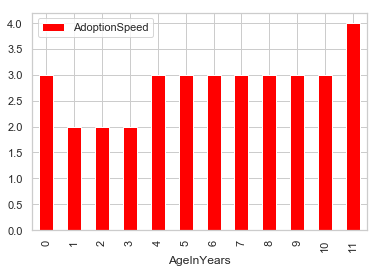

In [37]:
pivot.plot(kind='bar', color='red')

In [38]:
#let's check the mean Adoptation Speed per Age and plot it.
pivot = train.pivot_table(index='Age', values='AdoptionSpeed', aggfunc=np.median)
pivot.sort_index
#age in months


<bound method DataFrame.sort_index of      AdoptionSpeed
Age               
0              2.0
1              2.0
2              2.0
3              2.0
4              3.0
5              3.0
6              3.0
7              3.0
8              3.0
9              3.0
10             3.0
11             4.0
12             3.0
13             3.0
14             3.0
15             3.0
16             4.0
17             3.0
18             3.0
19             3.0
20             3.0
21             3.0
22             3.0
23             3.5
24             3.0
25             3.5
26             4.0
27             3.0
28             3.0
29             3.0
..             ...
81             3.0
82             0.0
84             3.0
85             3.0
86             2.0
87             1.0
88             2.0
89             2.0
91             2.0
92             2.0
95             4.0
96             3.0
100            2.0
102            4.0
108            4.0
112            1.0
117            1.0
120         

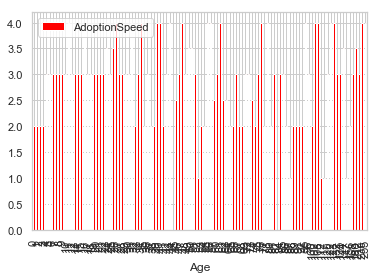

In [39]:
pivot.plot(kind='bar', color='red')

In [40]:
#let's check the mean Adoptation Speed per Age and plot it.
pivot = train.pivot_table(index='Breed1', values='AdoptionSpeed', aggfunc=np.median)
pivot.sort_index
#age in months

<bound method DataFrame.sort_index of         AdoptionSpeed
Breed1               
0                 3.0
1                 4.0
3                 4.0
5                 2.5
7                 4.0
10                3.0
11                4.0
15                3.0
16                4.0
17                3.0
18                3.0
19                3.0
20                2.0
21                3.0
23                2.0
24                1.5
25                4.0
26                2.0
31                2.0
32                2.0
39                3.0
42                2.0
44                2.5
49                3.0
50                2.5
56                3.0
58                2.5
60                2.0
61                0.0
64                3.0
...               ...
276               2.0
277               2.5
279               4.0
280               1.0
281               1.5
282               1.0
283               3.0
284               3.0
285               2.0
286               4.0
287             

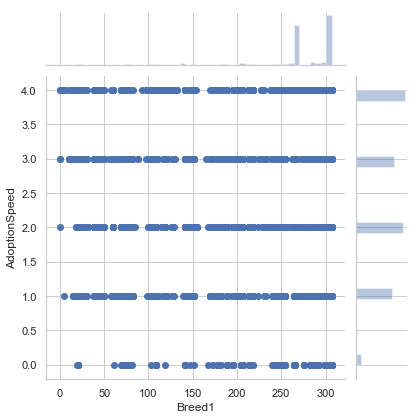

In [41]:
#GrLivArea variable
sns.jointplot(x=train['Breed1'], y=train['AdoptionSpeed'])

In [42]:
def prepare_data_without_text_columns(train_df, test_df, independent_cols, dependent_cols, identifier_cols):
    
    x_train= train[independent_cols]
    y_train = train[dependent_cols]
    x_test = test[independent_cols]
    id_test = test[identifier_cols]
    return x_train, y_train, x_test, id_test

ind_cont_columns = ["Age", "Fee","VideoAmt", "PhotoAmt"]
ind_num_cat_columns = ["Type","Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3","MaturitySize","FurLength",
                           "Vaccinated", "Dewormed", "Sterilized", "Health", "Quantity", "State"]
ind_cat_conv_columns = ["RescuerID"]
ind_text_columns = ["Name", "Description"]
iden_columns = ["PetID"]
dep_columns = ["AdoptionSpeed"]

#test without columns having text values (name and description) and rescuer_id
x_train, y_train, x_test, id_test = prepare_data_without_text_columns(train, test,ind_cont_columns+ind_num_cat_columns+ind_cat_conv_columns,dep_columns,iden_columns)

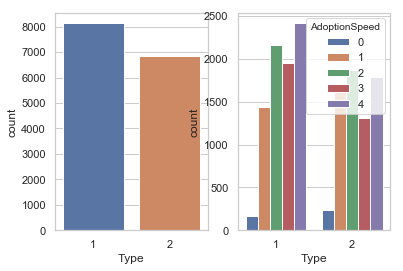

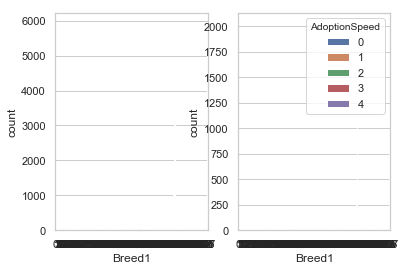

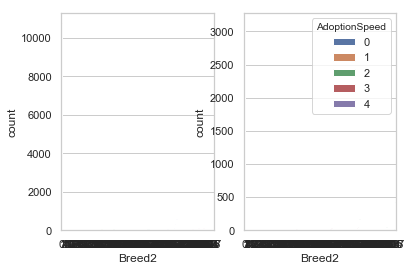

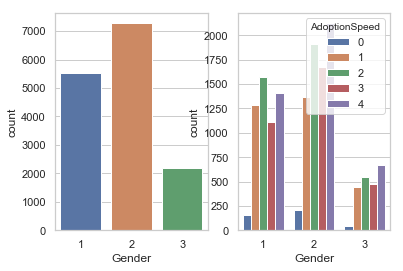

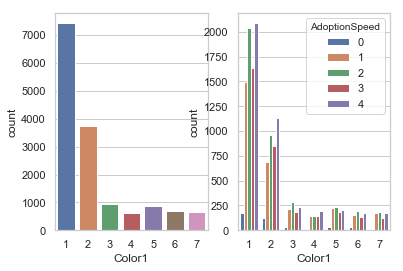

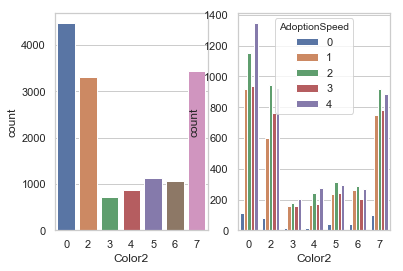

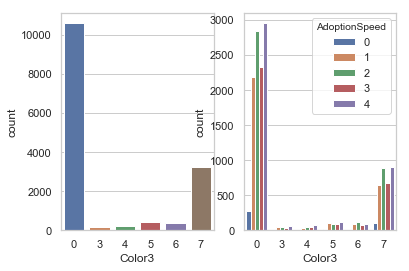

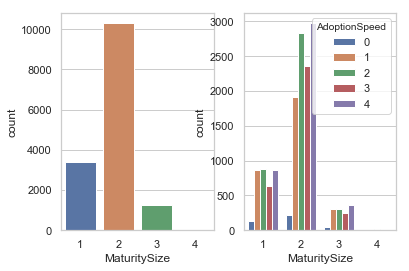

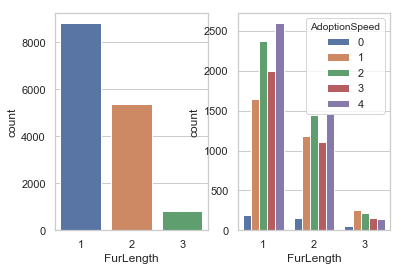

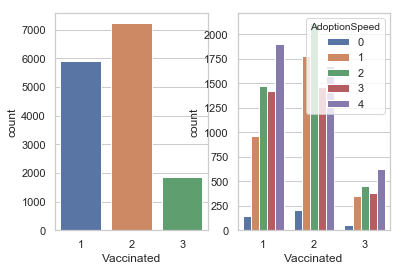

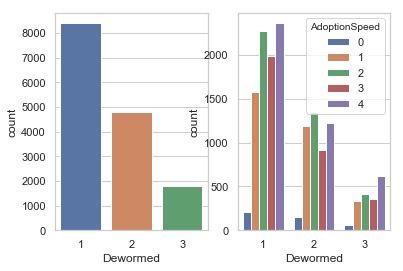

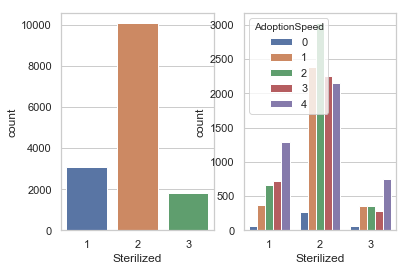

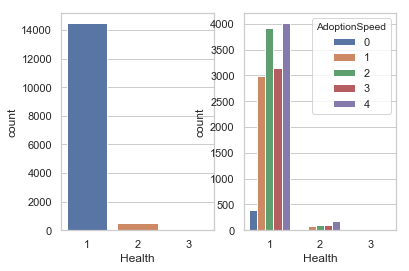

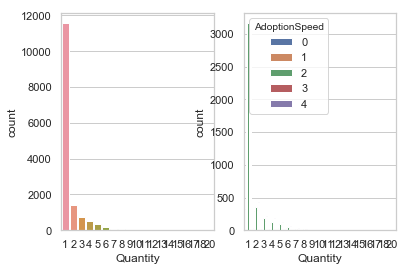

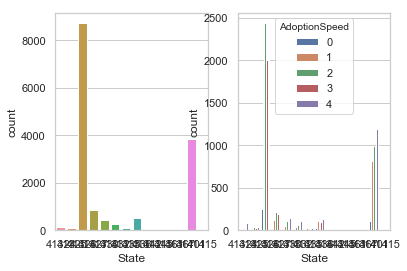

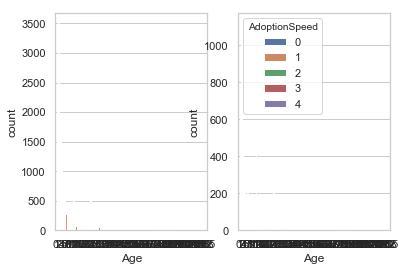

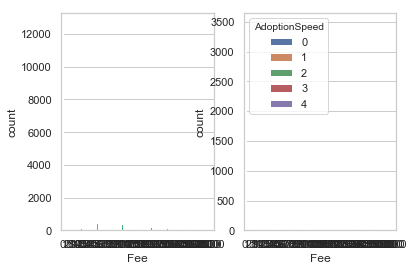

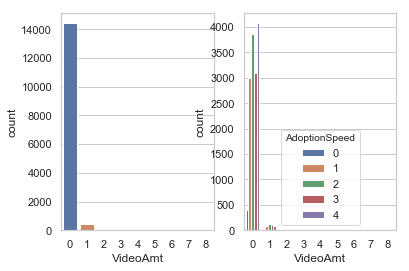

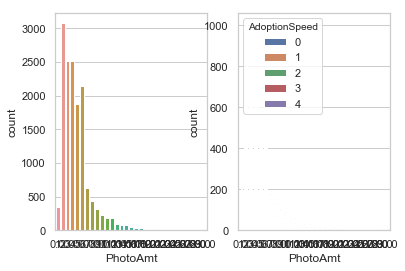

In [43]:
def check_cat_dist_plot(arr):

    #fig, axes = plt.subplots(1, 2)
    i = 0
    total = len(arr)
    for col in arr.columns.values:
        if col != "AdoptionSpeed":
            fig, axes = plt.subplots(1, 2)
            ax1 = sns.countplot(x=col, data=arr, ax= axes[0])
            #for p in ax1.patches:
            #    height = p.get_height()
            #    ax1.text(p.get_x() + p.get_width() / 2.,
            #            height + 3,
            #            '{:1.2f}'.format(height / total),
            #            ha="center")
            ax2 = sns.countplot(x=col, data=arr, hue="AdoptionSpeed", ax= axes[1])
            #for p in ax2.patches:
            #    height = p.get_height()
            #    ax2.text(p.get_x() + p.get_width() / 2.,
            #            height + 3,
            #            '{:1.2f}'.format(height / total),
            #            ha="center")
        plt.show()
            
check_cat_dist_plot(pd.concat([x_train[ind_num_cat_columns+ind_cont_columns], y_train],axis=1, sort=False))

